In [260]:
import pickle
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import FreqDist
from __future__ import division

%matplotlib inline
sns.set_style("darkgrid")

stop = stopwords.words('english')

In [116]:
with open("cubtweetsDF.pkl", "r") as picklefile:
    CubsDF = pickle.load(picklefile)

In [6]:
#The DF from Thursday - the first one and the one we use for charting in NVD3.
CubsDF.shape

(22396, 6)

In [14]:
#The most popular RT (@Cubs: #Cubs win! Cubs SWEEP!\n\nFinal: Cubs 9, #Brewers 2. #BroomEmoji http://t.co/VvPNcexXKg) was RT'd 1132 times.
#@MLB_ChicagoCubs tweeted the most, with 130 tweets during the game.

In [48]:
RTcount = CubsDF[CubsDF['text'].str.startswith('RT', na=False)]
CubsRTcount = CubsDF[CubsDF['text'].str.startswith('RT @Cubs', na=False)]

RTpercentage = len(RTcount)/len(CubsDF['text'])
CubsRTpercentage = len(CubsRTcount)/len(CubsDF['text'])

len(RTcount), RTpercentage, CubsRTpercentage
#over 49% of all tweets were RTs, and the @Cubs handle was responsible for nearly half of those.
#in fact, RTs of the offical @Cubs handle tweets, accounted for 22% of all tweets.

(10977, 0.4901321664582961, 0.22289694588319342)

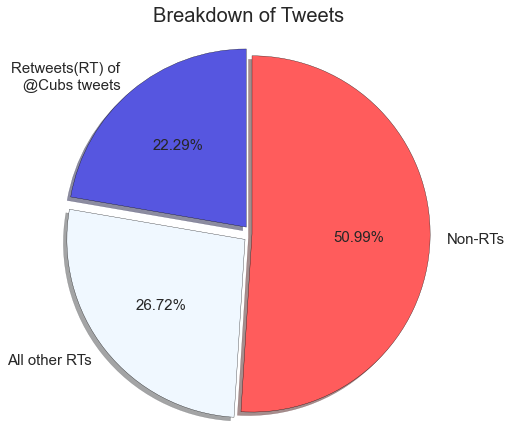

In [229]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig = plt.figure(figsize=(6,6))

#lets make a pie chart showing how prominent RTs are
labels = 'Retweets(RT) of \n@Cubs tweets', 'All other RTs', 'Non-RTs'
sizes = [CubsRTpercentage*100, (RTpercentage - CubsRTpercentage)*100, (1-RTpercentage)*100]
colors = ['#5656E0', 'aliceblue', '#FF5C5C']
explode = (0.05, 0.05, 0) # only "explode" the 2nd slice (i.e. 'Hogs')

patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)

for i in texts:
    i.set_fontsize(15)
for i in autotexts:
    i.set_fontsize(15)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("Breakdown of Tweets", fontsize = 20, y=1.06)

plt.savefig("Cubspie.png")
plt.show()

In [170]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']

def preprocess(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Remove www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    #Remove @username
    tweet = re.sub('@[^\s]+',' ',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim by removing single and double quotation marks
    tweet = tweet.strip('\'"')

    #look for 2 or more repetitions of character and replace with the character itself
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    tweet = pattern.sub(r"\1\1", tweet)
    #remove stopwords - need to break down into words first and then rejoin
    words = TextBlob(tweet).words
    tweet = " ".join([w for w in words if w not in stop])
    
    #some tweets will be empty, so let's replace w the string 'neutral'. This will be neutrally classified.
    
    #encode from unicode to string - only for MonkeyLearn. TextBlob actually wants unicode format.
    
    #currently commented out for textblob.
    #tweet = tweet.encode("utf-8")
    return tweet

In [118]:
CubsDF['text'] = CubsDF['text'].map(preprocess)
print 'Done preprocessing the whole DF.'

Done preprocessing the whole DF.


In [242]:
filtered_tokens = TextBlob(" ".join(list(CubsDF['text']))).words

In [253]:
freq_dist = nltk.FreqDist(filtered_tokens)

#sum(freq_dist.values()) = # of total words = 202870
total = sum(freq_dist.values())

In [244]:
freq_array = pd.Series(freq_dist).order(ascending = False)[:23]

In [245]:
fixed_array = freq_array.drop(freq_array.index[[0,1,7]])

#dropped RT, Cubs, and 's

In [250]:
freq_list = list(freq_dist)

In [254]:
norm_array = fixed_array.map(lambda x:x/total)
print norm_array

letsgo        0.014872
brewers       0.013575
2             0.013368
win           0.012501
hr            0.011653
schwarber     0.010973
sweep         0.008676
1             0.006822
game          0.006807
broomemoji    0.006502
games         0.006433
lead          0.006388
5th           0.006275
final         0.006117
9             0.006058
go            0.005989
home          0.005610
one           0.005565
7             0.005526
chicago       0.005467
dtype: float64


In [255]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'

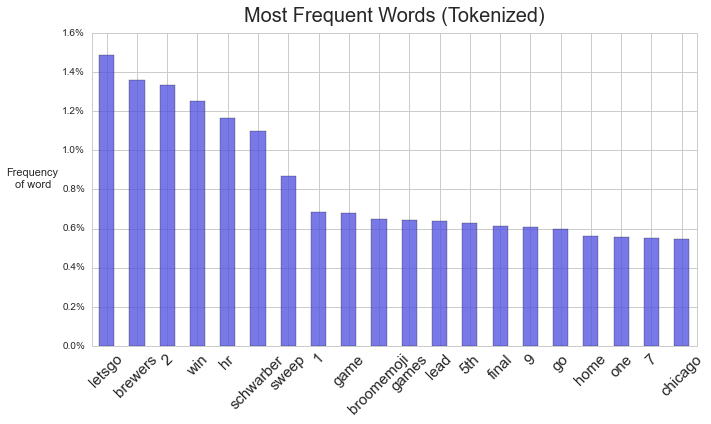

In [269]:
sns.set_style('whitegrid')

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

norm_array.plot(kind = 'bar', use_index=True, color='#5656E0', alpha=0.8)
ax.set_xticklabels(norm_array.index, rotation=45, fontsize = 15)
# ax.invert_yaxis()
plt.title("Most Frequent Words (Tokenized)", fontsize = 20, y=1.02)
plt.ylabel("Frequency\nof word", labelpad = 30).set_rotation(0)